<a href="https://colab.research.google.com/github/imallag/solana/blob/main/wallet_analyzer_solana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
from sqlalchemy import create_engine
import time
import re

def fetch_transactions(wallet_address, api_key, last_signature=None):
    base_url = f'https://api.helius.xyz/v0/addresses/{wallet_address}/transactions'
    params = {'api-key': api_key}
    all_transactions = []
    retries = 10

    while True:
        if last_signature:
            params['before'] = last_signature

        url = base_url
        print(f"Fetching transactions with URL: {url}, Params: {params}")  # Debugging line
        try:
            response = requests.get(url, params=params, timeout=30)
            if response.status_code == 200:
                transactions = response.json()
                if transactions:
                    all_transactions.extend(transactions)
                    print(f"Fetched {len(transactions)} transactions, total: {len(all_transactions)}")
                    last_signature = transactions[-1]['signature']
                else:
                    print("No more transactions available.")
                    break
            elif response.status_code == 400 or response.status_code == 404:
                error_msg = response.json().get('error', '')
                match = re.search(r"` parameter set to (.+)", error_msg)
                if match:
                    before_value = match.group(1).strip('. ')  # Strip trailing dot and space
                    print(f"Extracted 'before' value: {before_value}")  # Debugging line
                    last_signature = before_value
                    continue
                else:
                    print(f"Error fetching transactions: {response.status_code} - {response.text}")
                    break
            else:
                print(f"Error fetching transactions: {response.status_code} - {response.text}")
                break
        except requests.exceptions.Timeout:
            print("Request timed out. Retrying...")
            retries -= 1
            if retries == 0:
                print("Max retries reached. Exiting.")
                break
            time.sleep(5)
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            break

    return all_transactions

def transform_to_dataframe(transactions):
    data = []
    for tx in transactions:
        for transfer in tx.get('tokenTransfers', []):
            data.append({
                'wallet': tx.get('description', ''),
                'type': tx.get('type', ''),
                'source': tx.get('source', ''),
                'fee': tx.get('fee', 0),
                'feePayer': tx.get('feePayer', ''),
                'signature': tx.get('signature', ''),
                'slot': tx.get('slot', 0),
                'timestamp': tx.get('timestamp', 0),
                'fromTokenAccount': transfer.get('fromTokenAccount', ''),
                'toTokenAccount': transfer.get('toTokenAccount', ''),
                'fromUserAccount': transfer.get('fromUserAccount', ''),
                'toUserAccount': transfer.get('toUserAccount', ''),
                'tokenAmount': transfer.get('tokenAmount', 0),
                'mint': transfer.get('mint', ''),
                'tokenStandard': transfer.get('tokenStandard', '')
            })

    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df

def save_to_database(df, database_url, table_name):
    engine = create_engine(database_url)
    with engine.connect() as connection:
        df.to_sql(table_name, con=connection, if_exists='append', index=False)

def main():
    wallet_address = 'BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t'  # Replace with your wallet address
    api_key = 'api_key'  # Replace with your helius API key
    database_url = 'sqlite:///transactions.db'  # Replace with your database URL
    table_name = 'transactions'

    # Fetch transactions
    transactions = fetch_transactions(wallet_address, api_key)

    # Transform to DataFrame
    df = transform_to_dataframe(transactions)

    # Save DataFrame to database
    save_to_database(df, database_url, table_name)


if __name__ == "__main__":
    main()


Fetching transactions with URL: https://api.helius.xyz/v0/addresses/BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t/transactions, Params: {'api-key': '9f669bd3-6f59-4acb-a421-d7794d7118c1'}
Fetched 26 transactions, total: 26
Fetching transactions with URL: https://api.helius.xyz/v0/addresses/BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t/transactions, Params: {'api-key': '9f669bd3-6f59-4acb-a421-d7794d7118c1', 'before': '4jeKaFVf3PCagMbWgq3vTti5MviGyRSFtWoyrsTsh3h2q6to6gYws4o8cbvGfpHUQXCmmjNhu4RR84tnSWFhyeze'}
Fetched 23 transactions, total: 49
Fetching transactions with URL: https://api.helius.xyz/v0/addresses/BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t/transactions, Params: {'api-key': '9f669bd3-6f59-4acb-a421-d7794d7118c1', 'before': '5VbUpbhoMnK7y6gcRStNignuEQRwdcpc6B9p3WxyT554L4bPW1tdyDzDYdG9HB6BoG8iKjyBUdwoqvXyd4gQHnCb'}
Fetched 21 transactions, total: 70
Fetching transactions with URL: https://api.helius.xyz/v0/addresses/BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t/transactions, Par

In [2]:
import pandas as pd
from sqlalchemy import create_engine

# Replace with your database URL
database_url = 'sqlite:///transactions.db'

# Table name in your database
table_name = 'transactions'

# Create SQLAlchemy engine
engine = create_engine(database_url)

# Load data from the database into a DataFrame
df_from_db = pd.read_sql_table(table_name, con=engine)

# Display the DataFrame
print("DataFrame loaded from the database:")
print(df_from_db.head())  # Display first few rows

DataFrame loaded from the database:
                                              wallet      type   source  \
0  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t t...  TRANSFER  PHANTOM   
1  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...      SWAP  RAYDIUM   
2  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...      SWAP  RAYDIUM   
3  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...      SWAP  RAYDIUM   
4  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...      SWAP  RAYDIUM   

     fee                                      feePayer  \
0  15000  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t   
1  15125  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t   
2  15125  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t   
3  16140  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t   
4  16140  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t   

                                           signature       slot  \
0  4dyPUPeNyPyit9y3ir8bXKwqcutCXZpmr8xhw8ENT7JgDN...  280986749   
1  2x6xzo6U5PfZhGJMMzGbhd9ntav

In [10]:
df = df_from_db.copy()


In [11]:
# Function to expand rows by duplicating columns
def expand_grouped_data(grouped):
    max_len = grouped.applymap(lambda x: len(x.split(' | '))).max().max()

    expanded_df = pd.DataFrame()

    for col in grouped.columns:
        if col == 'signature':
            expanded_df[col] = grouped[col]
        else:
            expanded_cols = grouped[col].apply(lambda x: pd.Series(x.split(' | ')))
            expanded_cols.columns = [f"{col}_{i+1}" for i in range(max_len)]
            expanded_df = pd.concat([expanded_df, expanded_cols], axis=1)

    return expanded_df

# Group by 'signature' and apply the expansion function
grouped_df = df.groupby('signature').agg(lambda x: ' | '.join(x.astype(str))).reset_index()
expanded_df = expand_grouped_data(grouped_df)




<ipython-input-11-d23f0a8de643>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_len = grouped.applymap(lambda x: len(x.split(' | '))).max().max()


In [13]:
pd.set_option('display.max_colwidth', 15)

In [14]:
expanded_df = expanded_df[expanded_df['type_1'] == 'SWAP'].copy()

In [15]:
expanded_df = expanded_df.sort_values(by='timestamp_1')

In [16]:
expanded_df.drop(columns=['wallet_1', 'wallet_2', 'type_1', 'type_2', 'source_2', 'fee_2','feePayer_2', 'slot_2','timestamp_2', 'tokenStandard_1', 'tokenStandard_2' ], inplace=True)

In [17]:
# Update the function to include the 'action' column logic
def determine_transaction_action(row):
    if row['mint_1'] == 'So11111111111111111111111111111111111111112':
        row['action'] = 'buy'
    else:
        row['action'] = 'sell'


    return row


expanded_df = expanded_df.apply(determine_transaction_action, axis=1)

In [22]:
# Ensure tokenAmount_1 and tokenAmount_2 are cast to float
expanded_df['tokenAmount_1'] = expanded_df['tokenAmount_1'].astype(float)
expanded_df['tokenAmount_2'] = expanded_df['tokenAmount_2'].astype(float)

# Sort the dataframe by timestamp to ensure the correct order
expanded_df = expanded_df.sort_values(by='timestamp_1').reset_index(drop=True)

# Initialize the new sol_spent and sol_received columns
expanded_df['sol_spent'] = 0.0
expanded_df['sol_received'] = 0.0

In [23]:
# Iterate over each row and update the sol_spent and sol_received columns
for i in range(len(expanded_df)):
    row = expanded_df.iloc[i]
    mint_2 = row['mint_2']
    mint_1 = row['mint_1']
    tokenAmount_1 = row['tokenAmount_1']
    tokenAmount_2 = row['tokenAmount_2']

    # Update sol_spent
    if mint_2 != 'So11111111111111111111111111111111111111112':
        previous_rows = expanded_df[(expanded_df['mint_2'] == mint_2) & (expanded_df.index < i)]
        if not previous_rows.empty:
            last_row_index = previous_rows.index[-1]
            sol_spent_previous = expanded_df.at[last_row_index, 'sol_spent']
            expanded_df.at[i, 'sol_spent'] = sol_spent_previous + tokenAmount_1
        else:
            expanded_df.at[i, 'sol_spent'] = tokenAmount_1

    # Update sol_received
    if mint_1 != 'So11111111111111111111111111111111111111112':
        previous_rows = expanded_df[(expanded_df['mint_1'] == mint_1) & (expanded_df.index < i)]
        if not previous_rows.empty:
            last_row_index = previous_rows.index[-1]
            sol_received_previous = expanded_df.at[last_row_index, 'sol_received']
            expanded_df.at[i, 'sol_received'] = sol_received_previous + tokenAmount_2
        else:
            expanded_df.at[i, 'sol_received'] = tokenAmount_2

In [25]:
# Create the token column
expanded_df['token'] = expanded_df.apply(
    lambda row: row['mint_1'] if row['mint_1'] != 'So11111111111111111111111111111111111111112' else row['mint_2'],
    axis=1
)

# Create the trade_size column
expanded_df['trade_size'] = expanded_df.apply(
    lambda row: row['tokenAmount_1'] if row['action'] == 'sell' else row['tokenAmount_2'],
    axis=1
)


In [26]:
# Initialize the previous amount and new amount columns
expanded_df['previous amount'] = 0.0
expanded_df['new amount'] = 0.0

# Iterate over each row and update the previous amount and new amount columns
for i in range(len(expanded_df)):
    row = expanded_df.iloc[i]
    token = row['token']
    trade_size = row['trade_size']

    # Find the previous row with the same token
    previous_rows = expanded_df[(expanded_df['token'] == token) & (expanded_df.index < i)]
    if not previous_rows.empty:
        last_row_index = previous_rows.index[-1]
        previous_amount = expanded_df.at[last_row_index, 'new amount']
    else:
        previous_amount = 0.0

    # Set the previous amount
    expanded_df.at[i, 'previous amount'] = previous_amount

    # Calculate the new amount
    if row['action'] == 'buy':
        new_amount = previous_amount + trade_size
    elif row['action'] == 'sell':
        new_amount = previous_amount - trade_size

    # Set the new amount
    expanded_df.at[i, 'new amount'] = new_amount

In [27]:
# Calculate the trade_price column
expanded_df['trade_price'] = expanded_df.apply(
    lambda row: row['tokenAmount_1'] / row['tokenAmount_2'] if row['action'] == 'buy' else row['tokenAmount_2'] / row['tokenAmount_1'],
    axis=1
)

In [28]:
import numpy as np

# Initialize the final_pnl columns
expanded_df['final_pnl %'] = 0.0
expanded_df['final_pnl'] = 0.0

# Define a small threshold for floating point comparison
threshold = 1e-9

for i in range(len(expanded_df)):
    row = expanded_df.iloc[i]
    token = row['token']
    action = row['action']
    new_amount = row['new amount']

    # Check if action is 'sell' and new amount is close to zero
    if action == 'sell' and np.isclose(new_amount, 0, atol=threshold):
        # Find the previous row with the same token and action 'buy'
        previous_rows = expanded_df[(expanded_df['token'] == token) & (expanded_df['action'] == 'buy') & (expanded_df.index < i)]
        if not previous_rows.empty:
            last_row_index = previous_rows.index[-1]
            sol_spent_previous = expanded_df.at[last_row_index, 'sol_spent']
            sol_received_current = row['sol_received']
            if sol_spent_previous != 0:
                final_pnl_percentage = (sol_received_current / sol_spent_previous - 1) * 100  # Convert to percentage
                final_pnl = sol_received_current - sol_spent_previous  # Calculate absolute PnL
                expanded_df.at[i, 'final_pnl %'] = round(final_pnl_percentage, 5)
                expanded_df.at[i, 'final_pnl'] = round(final_pnl, 5)

In [29]:
# Initialize the accumulated_pnl column
expanded_df['accumulated_pnl'] = 0.0

# Initialize the accumulated PnL
accumulated_pnl = 0.0

for i in range(len(expanded_df)):
    row = expanded_df.iloc[i]
    final_pnl = row['final_pnl']

    # Accumulate the PnL
    accumulated_pnl += final_pnl
    expanded_df.at[i, 'accumulated_pnl'] = round(accumulated_pnl, 5)


In [34]:
# Ensure final_pnl is cast to float
expanded_df['final_pnl'] = expanded_df['final_pnl'].astype(float)

# Create pnl_df which contains all the rows from expanded_df where final_pnl != 0
pnl_df = expanded_df[expanded_df['final_pnl'] != 0].reset_index(drop=True)

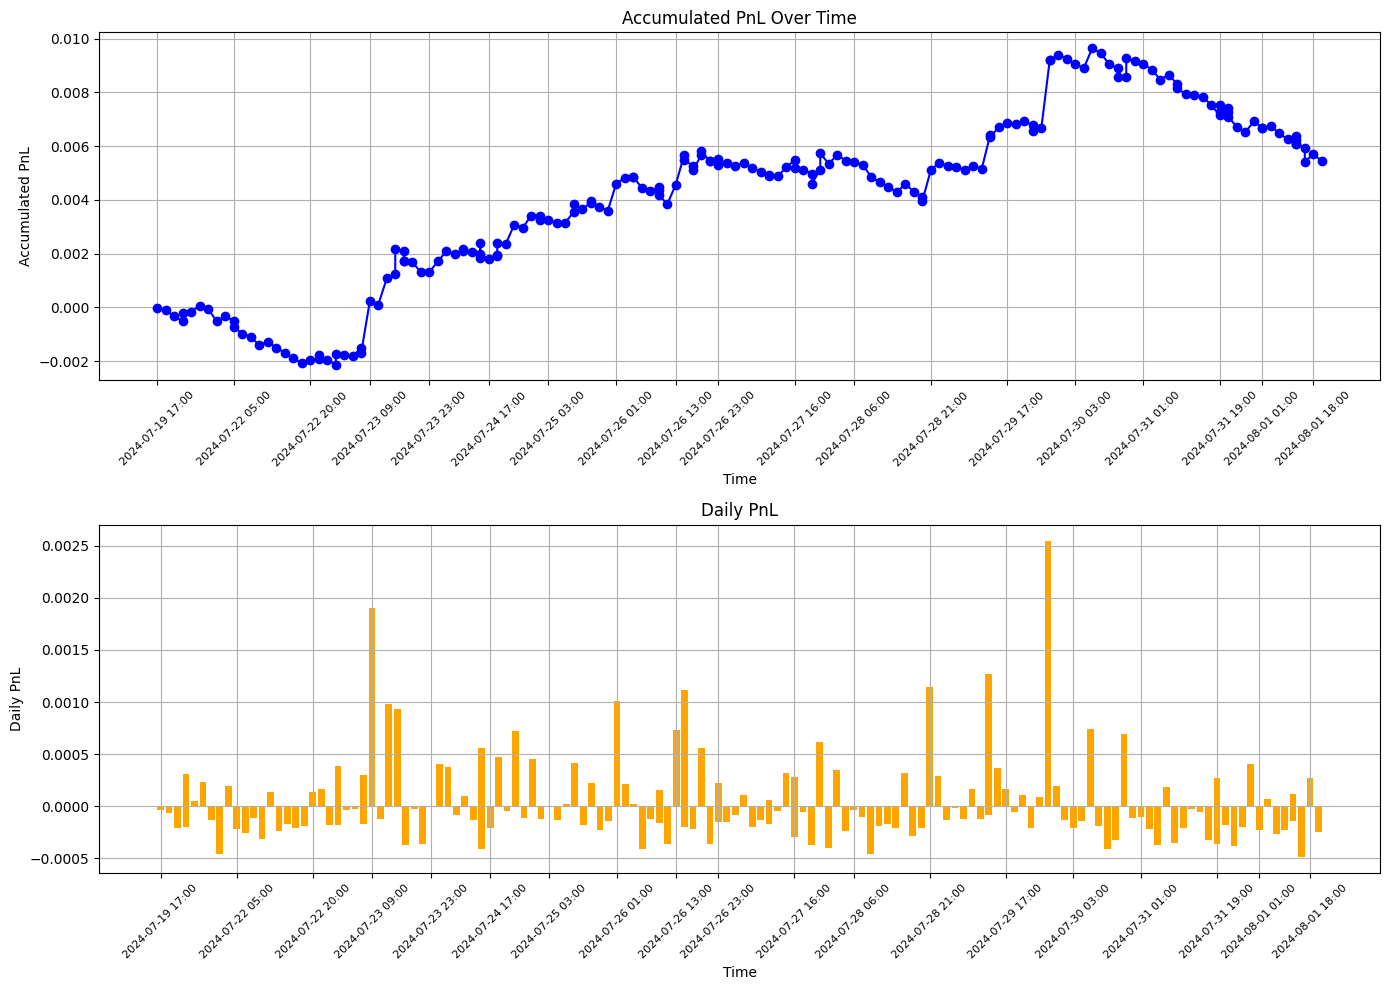

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert timestamps to only date and hour
pnl_df['timestamp_1'] = pd.to_datetime(pnl_df['timestamp_1']).dt.strftime('%Y-%m-%d %H:00')

# Plot the accumulated PnL over time
plt.figure(figsize=(14, 10))

# Plot cumulative PnL
plt.subplot(2, 1, 1)
plt.plot(pnl_df['timestamp_1'], pnl_df['accumulated_pnl'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Accumulated PnL')
plt.title('Accumulated PnL Over Time')
plt.xticks(ticks=pnl_df['timestamp_1'][::10], rotation=45, fontsize=8)  # Show every 10th label
plt.grid()

# Plot daily PnL
plt.subplot(2, 1, 2)
plt.bar(pnl_df['timestamp_1'], pnl_df['final_pnl'], color='orange')
plt.xlabel('Time')
plt.ylabel('Daily PnL')
plt.title('Daily PnL')
plt.xticks(ticks=pnl_df['timestamp_1'][::10], rotation=45, fontsize=8)  # Show every 10th label
plt.grid()

plt.tight_layout()
plt.show()

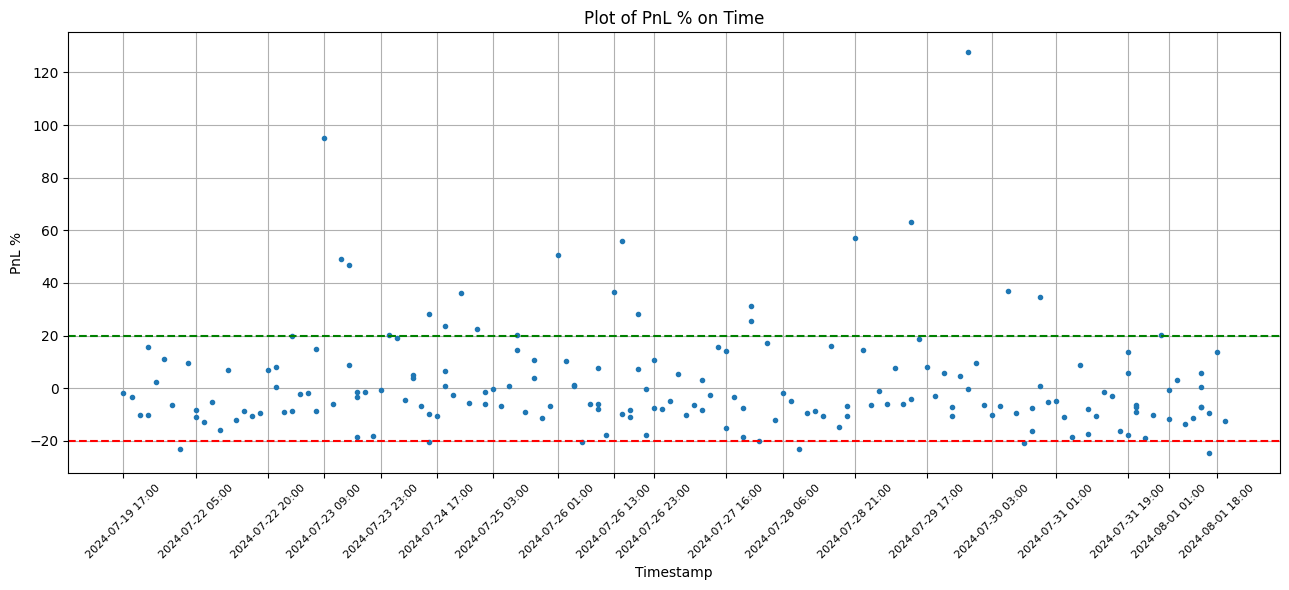

In [39]:
# Create the new plot
plt.figure(figsize=(13, 6))
plt.plot(pnl_df['timestamp_1'], pnl_df['final_pnl %'], marker='o', markersize=3, linestyle='')
plt.title('Plot of PnL % on Time')
plt.axhline(y=-20, color='red', linestyle='--', label='-20%')
plt.axhline(y=20, color='green', linestyle='--', label='20%')
plt.xlabel('Timestamp')
plt.ylabel('PnL %')
plt.xticks(ticks=pnl_df['timestamp_1'][::10], rotation=45, fontsize=8)  # Show every 10th label
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-40-a0a2b9676cb5>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pnl_df['final_pnl %'], shade=True, color='b', label='Density')


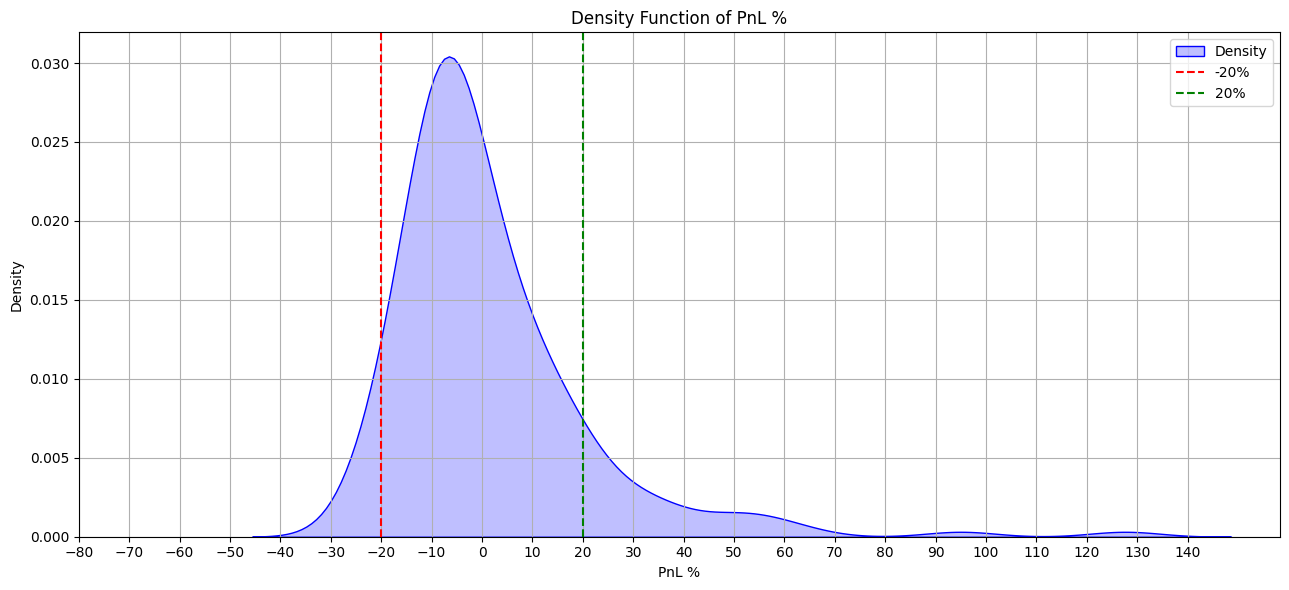

In [40]:
import seaborn as sns

plt.figure(figsize=(13, 6))
sns.kdeplot(pnl_df['final_pnl %'], shade=True, color='b', label='Density')
plt.axvline(x=-20, color='red', linestyle='--', label='-20%')
plt.axvline(x=20, color='green', linestyle='--', label='20%')
plt.title('Density Function of PnL %')
plt.xlabel('PnL %')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(range(-80, 150, 10))

plt.show()

In [41]:
# Basic statistics for final_pnl
mean_pnl = pnl_df['final_pnl'].mean()
median_pnl = pnl_df['final_pnl'].median()
std_pnl = pnl_df['final_pnl'].std()
min_pnl = pnl_df['final_pnl'].min()
max_pnl = pnl_df['final_pnl'].max()
percentiles_pnl = pnl_df['final_pnl'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
total_pnl = pnl_df['final_pnl'].sum()

print(f"Mean PnL: {mean_pnl:.6f}")
print(f"Median PnL: {median_pnl:.6f}")
print(f"Standard Deviation of PnL: {std_pnl:.6f}")
print(f"Minimum PnL: {min_pnl:.6f}")
print(f"Maximum PnL: {max_pnl:.6f}")
print(f"10th Percentile PnL: {percentiles_pnl[0.1]:.6f}")
print(f"25th Percentile PnL: {percentiles_pnl[0.25]:.6f}")
print(f"50th Percentile (Median) PnL: {percentiles_pnl[0.5]:.6f}")
print(f"75th Percentile PnL: {percentiles_pnl[0.75]:.6f}")
print(f"90th Percentile PnL: {percentiles_pnl[0.9]:.6f}")
print(f"Total PnL: {total_pnl:.6f}")

# Basic statistics for final_pnl %
mean_pnl_percent = pnl_df['final_pnl %'].mean()
median_pnl_percent = pnl_df['final_pnl %'].median()
std_pnl_percent = pnl_df['final_pnl %'].std()
min_pnl_percent = pnl_df['final_pnl %'].min()
max_pnl_percent = pnl_df['final_pnl %'].max()
percentiles_pnl_percent = pnl_df['final_pnl %'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
total_pnl_percent = pnl_df['final_pnl %'].sum()

print(f"\nMean PnL %: {mean_pnl_percent:.2f}")
print(f"Median PnL %: {median_pnl_percent:.2f}")
print(f"Volatility (Standard Deviation) PnL %: {std_pnl_percent:.2f}")
print(f"Minimum PnL %: {min_pnl_percent:.2f}")
print(f"Maximum PnL %: {max_pnl_percent:.2f}")
print(f"10th Percentile PnL %: {percentiles_pnl_percent[0.1]:.2f}")
print(f"25th Percentile PnL %: {percentiles_pnl_percent[0.25]:.2f}")
print(f"50th Percentile (Median) PnL %: {percentiles_pnl_percent[0.5]:.2f}")
print(f"75th Percentile PnL %: {percentiles_pnl_percent[0.75]:.2f}")
print(f"90th Percentile PnL %: {percentiles_pnl_percent[0.9]:.2f}")
print(f"Total PnL %: {total_pnl_percent:.2f}")

Mean PnL: 0.000030
Median PnL: -0.000090
Standard Deviation of PnL: 0.000396
Minimum PnL: -0.000490
Maximum PnL: 0.002550
10th Percentile PnL: -0.000318
25th Percentile PnL: -0.000190
50th Percentile (Median) PnL: -0.000090
75th Percentile PnL: 0.000150
90th Percentile PnL: 0.000409
Total PnL: 0.005450

Mean PnL %: 1.50
Median PnL %: -4.57
Volatility (Standard Deviation) PnL %: 19.82
Minimum PnL %: -24.60
Maximum PnL %: 127.60
10th Percentile PnL %: -15.94
25th Percentile PnL %: -9.58
50th Percentile (Median) PnL %: -4.57
75th Percentile PnL %: 7.45
90th Percentile PnL %: 20.26
Total PnL %: 272.31


In [42]:
pnl_df.describe()

,tokenAmount_1,tokenAmount_2,sol_spent,sol_received,trade_size,previous amount,new amount,trade_price,final_pnl %,final_pnl,accumulated_pnl
count,182.000000,182.000000,182.0,182.000000,182.000000,182.000000,1.820000e+02,1.820000e+02,182.000000,182.000000,182.000000
mean,16372.883001,0.001999,0.0,0.002030,16372.883001,16372.883001,-4.934758e-14,2.342866e-07,1.496204,0.000030,0.004187
std,15690.576765,0.000448,0.0,0.000396,15690.576765,15690.576765,6.744733e-13,2.516669e-07,19.819253,0.000396,0.003134
min,574.553403,0.000206,0.0,0.001508,574.553403,574.553403,-9.094947e-12,1.758167e-08,-24.595200,-0.000490,-0.002130
25%,7169.289356,0.001800,0.0,0.001808,7169.289356,7169.289356,0.000000e+00,1.016210e-07,-9.583562,-0.000190,0.002012
50%,10396.948847,0.001897,0.0,0.001909,10396.948847,10396.948847,0.000000e+00,1.844425e-07,-4.574575,-0.000090,0.004885
75%,19134.045823,0.002139,0.0,0.002149,19134.045823,19134.045823,0.000000e+00,2.790040e-07,7.452450,0.000150,0.006363
max,110526.986586,0.004552,0.0,0.004552,110526.986586,110526.986586,2.273737e-13,2.036161e-06,127.604200,0.002550,0.009650
